<a href="https://colab.research.google.com/github/dlwub/Final_Project_AIMS/blob/main/Final_Project_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory (LSTM)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

In [ ]:
!unzip /content/Project_data-20240613T204603Z-001.zip

Archive:  /content/Project_data-20240613T204603Z-001.zip
  inflating: Project_data/CPI.csv    
  inflating: Project_data/Unemployment_rate.csv  
  inflating: Project_data/PPI_Industrial.csv  
  inflating: Project_data/Exchange_rate.csv  
  inflating: Project_data/Money_supply.csv  
  inflating: Project_data/Retail_sales_value.csv  
  inflating: Project_data/FGC_Expenditure.csv  
  inflating: Project_data/Trade_balance.csv  
  inflating: Project_data/Real_GDP.csv  
  inflating: Project_data/Unemployment_rate_2.csv  
  inflating: Project_data/Retail_sales_volume.csv  
  inflating: Project_data/Labor_force.csv  
  inflating: Project_data/PPI_Manufacturing_Industrial.csv  
  inflating: Project_data/Interest_rate.csv  
  inflating: Project_data/PPI_Manufacturing.csv  
  inflating: Project_data/Money_supply_M3.csv  


In [ ]:
mergedData = pd.read_csv("/content/mergedData.csv")

In [ ]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length, :-1])
        targets.append(data[i + sequence_length, -1])
    return np.array(sequences), np.array(targets)

In [ ]:
def create_model(X_train):
  model = Sequential([
      LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])),
      Dense(100, activation='relu'),
      Dense(1)
    ])
  return model

In [ ]:
def get_train_test_sets(sequence_length):
  dataset = mergedData.drop(mergedData.columns[0], axis=1)
  values = dataset.values
  X, y = values[:, :-1], values[:, -1:]
  scaler_x = MinMaxScaler()
  scaler_y = MinMaxScaler()
  scaled_x = scaler_x.fit_transform(X)
  scaled_y = scaler_y.fit_transform(y)
  scaled_data = np.hstack((scaled_x, scaled_y))
  X, y = create_sequences(scaled_data, sequence_length)
  train_size = int(len(X)*0.8)
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]
  return X_train, y_train, X_test, y_test, scaler_y

In [ ]:
def train_model(X_train, y_train, X_test, y_test, epochs):
  model = create_model(X_train)
  model.compile(optimizer='adam', loss='mse')

  # Train the Model
  model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)
  return model

In [ ]:
def get_inverted_values(X_train, y_train, X_test, y_test, scaler_y, model):
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
  y_train = y_train.reshape(-1, 1)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  train_pred_inv = scaler_y.inverse_transform(train_pred.reshape(-1, 1))
  test_pred_inv = scaler_y.inverse_transform(test_pred.reshape(-1, 1))
  y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
  y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
  return train_pred_inv, test_pred_inv, y_train_inv, y_test_inv

In [ ]:
def get_metrics_values(train_pred_inv, test_pred_inv, y_train_inv, y_test_inv):
  mae_train = mean_absolute_error(y_train_inv, train_pred_inv)
  mae_test = mean_absolute_error(y_test_inv, test_pred_inv)
  rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
  rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
  return mae_train, mae_test, rmse_train, rmse_test

### Feature Importance

In [ ]:
def plot_importance_graph(model):
  results = permutation_importance(model, X_train, y_train, scoring='neg_mean_squared_error')
  importance = results.importances_mean
  importance_sum = np.sum(np.abs(importance))
  importance_ = importance/importance_sum
  indices = np.argsort(importance_)
  plt.barh(range(X_train.shape[1]), importance_[indices])
  plt.yticks(range(X_train.shape[1]), mergedData.columns[1:-1][indices])
  plt.xlabel('Feature Importance')
  plt.ylabel('Features')
  plt.show()

### Plotting the curve

In [ ]:
# Plot predicted vs real values with dates on the x-axis
def plot_graph(y_test_inv, test_pred_inv):
  test_date = mergedData.iloc[-len(y_test_inv):, 0]
  plt.figure(figsize=(10, 5))
  plt.plot(test_date, y_test_inv, label='Real Values', marker='o')
  plt.plot(test_date, test_pred_inv, label='Predicted Values', marker='x')
  plt.xlabel('Dates', fontsize=12)
  plt.ylabel('CPI', fontsize=12)
  #plt.title('Predicted vs Real Values (LSTM - test prediction)')
  plt.xticks(rotation=45)
  plt.xticks(range(0, len(test_date), 6), test_date[::6], fontsize=12)
  plt.yticks(fontsize=12)
  rmse = float(format(np.sqrt(mean_squared_error(y_test_inv, test_pred_inv.ravel())),'.2f'))
  results = {}
  mae = float(format(mean_absolute_error(y_test_inv, test_pred_inv.ravel()), '.2f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test_inv, test_pred_inv.ravel())), '.2f'))

  print({'MAE': mae, 'RMSE': rmse})
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

### Running the model multiple times

In [ ]:
scores = {'MAE_train': float('inf'), 'MAE_test': float('inf'), 'RMSE_train': float('inf'), 'RMSE_test': float('inf')}
X_train, y_train, X_test, y_test, scaler_y = get_train_test_sets(6)

for i in range(400):
  model = train_model(X_train, y_train, X_test, y_test, 150)
  train_pred_inv, test_pred_inv, y_train_inv, y_test_inv = get_inverted_values(X_train, y_train, X_test, y_test, scaler_y, model)
  mae_train, mae_test, rmse_train, rmse_test = get_metrics_values(train_pred_inv, test_pred_inv, y_train_inv, y_test_inv)
  if mae_test < scores['MAE_test'] and rmse_test < scores['RMSE_test']:
    scores['MAE_train'] = mae_train
    scores['MAE_test'] = mae_test
    scores['RMSE_train'] = rmse_train
    scores['RMSE_test'] = rmse_test
    model.save('/content/lstm_model.h5', overwrite=True)
model = load_model('/content/lstm_model.h5')

3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 3ms/step


In [ ]:
scores

{'MAE_train': 0.46316944216105266,
 'MAE_test': 1.6568174901394692,
 'RMSE_train': 0.5927998786430183,
 'RMSE_test': 1.87936554794569}

In [ ]:
X_train, y_train, X_test, y_test, scaler_y = get_train_test_sets(6)
model = load_model("/content/lstm_model.h5")
train_pred_inv, test_pred_inv, y_train_inv, y_test_inv = get_inverted_values(X_train, y_train, X_test, y_test, scaler_y, model)

3/3 [==============================] - 0s 12ms/step


{'MAE': 1.66, 'RMSE': 1.88}


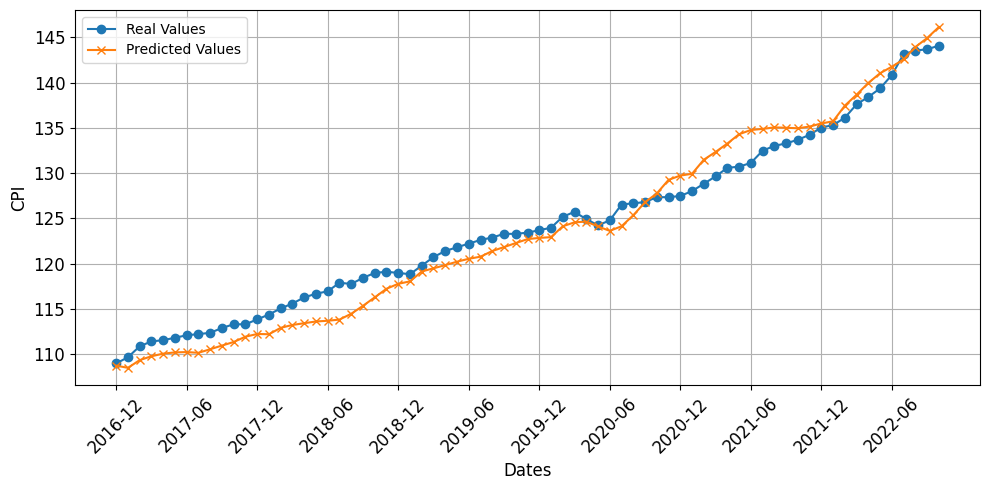

In [ ]:
plot_graph(y_test_inv, test_pred_inv)

In [ ]:
df5 = pd.DataFrame({'Predicted value': test_pred_inv.flatten(), 'Real Value': y_test_inv.flatten()})
df5

,Predicted value,Real Value
0,108.718552,108.968156
1,108.480659,109.643299
2,109.328987,110.858557
3,109.756180,111.398672
4,110.046188,111.533701
...,...,...
66,141.748032,140.834927
67,142.560776,143.130415
68,143.923111,143.535501
69,144.911407,143.670530


In [ ]:
model.summary()

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 200)               168800    
                                                                 
 dense_270 (Dense)           (None, 100)               20100     
                                                                 
 dense_271 (Dense)           (None, 1)                 101       
                                                                 
Total params: 189001 (738.29 KB)
Trainable params: 189001 (738.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Feature importance through weights

In [ ]:
def get_feature_importance_weights(model):
  weights = model.get_weights()[0]
  feature_importance_weight = np.mean(np.abs(weights), axis=1)
  return feature_importance_weight

In [ ]:
def plot_importance_graph(importance, n_features):
  importance_sum = np.sum(np.abs(importance))
  importance_ = importance/importance_sum
  indices = np.argsort(importance_)
  plt.barh(range(n_features), importance_[indices])
  plt.xticks(fontsize=12)
  plt.yticks(range(n_features), mergedData.columns[1:-1][indices], fontsize=12)
  plt.xlabel('Feature Importance', fontsize=14)
  plt.ylabel('Features', fontsize=14)
  plt.show()

In [ ]:
importance_weights = get_feature_importance_weights(model)

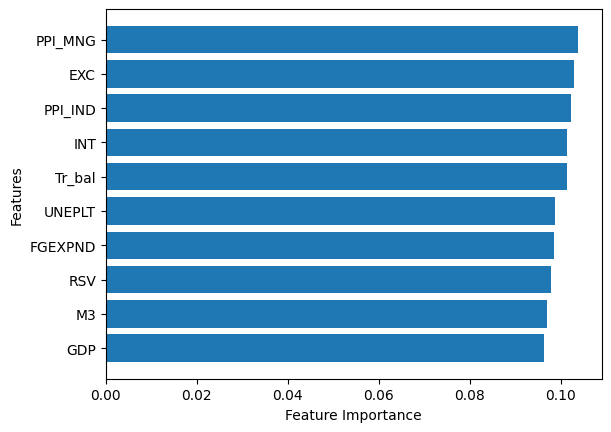

In [ ]:
plot_importance_graph(importance_weights, 10)

### Feature importance through permutation importance

In [ ]:
def get_permutation_importance(model, X, y, n_features):
  baseline_pred = model.predict(X)
  baseline_score = np.sqrt(mean_squared_error(y, baseline_pred))

  # Compute permutation importance
  feature_importance_permutation = np.zeros(n_features)
  for i in range(n_features):
      X_permuted = X.copy()
      np.random.shuffle(X_permuted[:, :, i])
      permuted_pred = model.predict(X_permuted)
      permuted_score = np.sqrt(mean_squared_error(y, permuted_pred))
      feature_importance_permutation[i] = np.abs(baseline_score - permuted_score)
  return feature_importance_permutation

In [ ]:
permutation_importance = get_permutation_importance(model, X_test, y_test, 10)

3/3 [==============================] - 0s 3ms/step


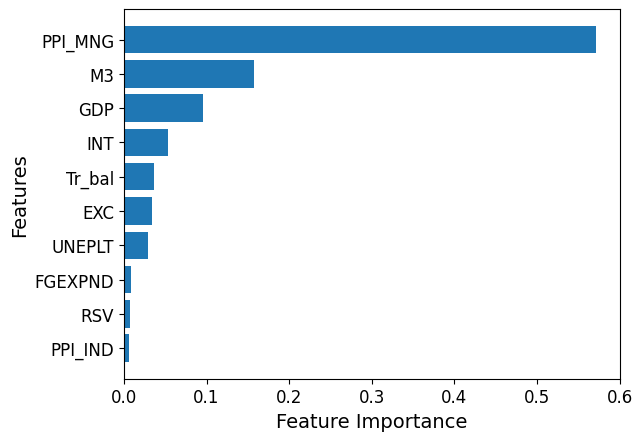

In [ ]:
plot_importance_graph(permutation_importance, 10)